In [1]:
# import argparse

# parser = argparse.ArgumentParser(description="Choose RNN module: LSTM or GRU")
# parser.add_argument("--rnn_module", type=str, default="LSTM", help="Choose RNN module: LSTM or GRU")
# args = parser.parse_args()

#Choose GRU or LSTM here

#rnn = "GRU"
rnn = "LSTM"

In [2]:
import os
current_working_directory = os.getcwd()
print(current_working_directory)

import matplotlib.pyplot as plt


import numpy as np 
import torch 
import torch.nn as nn 
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
import scipy.io as sio

from tqdm import trange, tqdm

# Import the single DOF finite difference model
from mlp_singledof_rnn import MLP, MLPProjectionFilter, CustomGRULayer, GRU_Hidden_State, CustomLSTMLayer, LSTM_Hidden_State



/home/alinjar/simple_training_warm_start/RNN


In [3]:
class TrajDataset(Dataset):
    """Expert Trajectory Dataset."""
    def __init__(self, inp, theta_init, v_start):
        # input
        self.inp = inp 
        self.theta_init = theta_init
        self.v_start = v_start
        

    def __len__(self):
        return len(self.inp)    

    def __getitem__(self, idx):
        # Input
        inp = self.inp[idx]
        theta_init = self.theta_init[idx]
        v_start = self.v_start[idx]
        

        return (torch.tensor(inp).float(),
                torch.tensor(theta_init).float(),
                torch.tensor(v_start).float())
                

In [4]:
def sample_uniform_trajectories(key, var_min, var_max, dataset_size, nvar):
    rng = np.random.default_rng(seed=key)
    xi_samples = rng.uniform(
        low=var_min,
        high=var_max,
        size=(dataset_size, nvar)
    )
    return xi_samples, rng

In [5]:
#Parameters for MLP model

num_batch = 1000
num_dof=1
num_steps=50
timestep=0.05
v_max=2.0
a_max=5.0
j_max=10.0
p_max=180.0*np.pi/180.0 
theta_init=0.0
maxiter_projection = 5
nvar_single = num_steps
nvar = num_dof * nvar_single
theta_init_min=-np.pi
theta_init_max=np.pi

In [6]:
#calculating number of constraints
num_acc = num_steps - 1
num_jerk = num_acc - 1
num_pos = num_steps
num_vel_constraints = 2 * num_steps * num_dof
num_acc_constraints = 2 * num_acc * num_dof
num_jerk_constraints = 2 * num_jerk * num_dof
num_pos_constraints = 2 * num_pos * num_dof
num_total_constraints = (num_vel_constraints + num_acc_constraints + 
                            num_jerk_constraints + num_pos_constraints)




In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

#### creating dataset

dataset_size = num_batch*20 #200000

theta_init, rng_theta_init = sample_uniform_trajectories(41, var_min= theta_init_min, var_max = theta_init_max, dataset_size=dataset_size, nvar=1)
#print("theta_init", theta_init.shape)
v_start, rng_v_start = sample_uniform_trajectories(40, var_min =-1.0*v_max, var_max = 1.0*v_max, dataset_size=dataset_size, nvar=1)
#print("v_start", v_start.shape)

#For training
xi_samples, rng = sample_uniform_trajectories(42, var_min=-v_max, var_max=v_max ,dataset_size=dataset_size, nvar=nvar)

#For validation
xi_val, rng_val = sample_uniform_trajectories(43, var_min=-v_max, var_max=v_max ,dataset_size=dataset_size, nvar=nvar)

# xi_samples = torch.from_numpy(xi_samples)
# xi_val = torch.from_numpy(xi_val)

inp = np.hstack(( xi_samples, theta_init, v_start))

inp_val = np.hstack(( xi_val, theta_init, v_start))

Using cuda device


In [8]:
print("inp_mean", inp.mean())
print("inp_std", inp.std())

inp_mean -0.00021612548686851649
inp_std 1.170775849409243


In [9]:

# A Torch version of the same is used in decoder function of corresponding MLP class for training
#Statistical Parameters:Median, Q1, Q3, IQR for all features

inp_median_ = np.median(inp, axis=0)
inp_q1 = np.percentile(inp, 25, axis=0)
inp_q3 = np.percentile(inp, 75, axis=0)
inp_iqr_ = inp_q3 - inp_q1


# Handle constant features
inp_iqr_ = np.where(inp_iqr_ == 0, 1, inp_iqr_)

print("input shape: ", inp.shape)
print(inp_median_.shape)
print(inp_q1.shape)
print(inp_q3.shape)
print(inp_iqr_.shape)

# print(np.array_repr(inp_median_))
# print(np.array_repr(inp_iqr_))


inp_val_median_ = np.median(inp_val, axis=0)
inp_val_q1 = np.percentile(inp_val, 25, axis=0)
inp_val_q3 = np.percentile(inp_val, 75, axis=0)
inp_val_iqr_ = inp_val_q3 - inp_val_q1


# Handle constant features
inp_val_iqr_ = np.where(inp_val_iqr_ == 0, 1, inp_val_iqr_)

print("input shape: ", inp_val.shape)
print(inp_val_median_.shape)
print(inp_val_q1.shape)
print(inp_val_q3.shape)
print(inp_val_iqr_.shape)

# print(np.array_repr(inp_median_))
# print(np.array_repr(inp_iqr_))



input shape:  (20000, 52)
(52,)
(52,)
(52,)
(52,)
input shape:  (20000, 52)
(52,)
(52,)
(52,)
(52,)


In [10]:
# Using PyTorch Dataloader
train_dataset = TrajDataset(inp, theta_init, v_start)
val_dataset = TrajDataset(inp_val, theta_init, v_start)

train_loader = DataLoader(train_dataset, batch_size=num_batch, shuffle=True, num_workers=0, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=num_batch, shuffle=True, num_workers=0, drop_last=True)


In [11]:

if rnn == "GRU":
    print("Training with GRU")
    #GRU handling
    rnn = "GRU"
    gru_input_size = 3*num_total_constraints+3*nvar
    # print(gru_input_size)
    gru_hidden_size = 512
    # gru_output_size = (2*nvar)**2+2*nvar
    gru_output_size = num_total_constraints+nvar
    # gru_context_size = mlp_planner_inp_dim

    gru_context = CustomGRULayer(gru_input_size, gru_hidden_size, gru_output_size)

    rnn_context = gru_context


    input_hidden_state_init = np.shape(inp)[1]
    mid_hidden_state_init = 512
    out_hidden_state_init = gru_hidden_size

    gru_init  =  GRU_Hidden_State(input_hidden_state_init, mid_hidden_state_init, out_hidden_state_init)
    
    rnn_init = gru_init
    ##
elif rnn == "LSTM":
    print("Training with LSTM")
    #LSTM handling
    rnn = "LSTM"
    lstm_input_size = 3*num_total_constraints+3*nvar
    # print(lstm_input_size)
    lstm_hidden_size = 512
    # lstm_output_size = (2*nvar)**2+2*nvar
    lstm_output_size = num_total_constraints+nvar
    # lstm_context_size = mlp_planner_inp_dim

    lstm_context = CustomLSTMLayer(lstm_input_size, lstm_hidden_size, lstm_output_size)

    rnn_context = lstm_context

    input_hidden_state_init = np.shape(inp)[1]
    mid_hidden_state_init = 512
    out_hidden_state_init = lstm_hidden_size

    lstm_init = LSTM_Hidden_State(input_hidden_state_init, mid_hidden_state_init, out_hidden_state_init)

    rnn_init = lstm_init

    ##

##


Training with LSTM


In [12]:

enc_inp_dim = np.shape(inp)[1] 
mlp_inp_dim = enc_inp_dim
hidden_dim = 1024
mlp_out_dim = 2*nvar + num_total_constraints #( xi_samples- 0:nvar, lamda_smples- nvar:2*nvar)

mlp =  MLP(mlp_inp_dim, hidden_dim, mlp_out_dim)

In [13]:


model = MLPProjectionFilter(mlp=mlp,rnn_context=rnn_context, rnn_init = rnn_init, num_batch = num_batch,num_dof=num_dof,num_steps=num_steps,
							timestep=timestep,v_max=v_max,a_max=a_max,j_max=j_max,p_max=p_max, 
							maxiter_projection=maxiter_projection, rnn=rnn).to(device)

print(type(model))                            

<class 'mlp_singledof_rnn.MLPProjectionFilter'>


In [14]:
epochs = 100
#step, beta = 0, 1.0 # 3.5
optimizer = optim.AdamW(model.parameters(), lr = 1e-4, weight_decay=6e-5)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 30, gamma = 0.1, verbose=True)

losses = []
last_loss = torch.inf
avg_train_loss, avg_primal_loss, avg_fixed_point_loss, avg_projection_loss = [], [], [], []
avg_val_loss = []
for epoch in range(epochs):
    
    # Train Loop
    losses_train, primal_losses, fixed_point_losses, projection_losses = [], [], [], []
    
    for (inp, theta_init, v_start) in tqdm(train_loader):
        
        # Input and Output 
        inp = inp.to(device)
        theta_init = theta_init.to(device)
        v_start = v_start.to(device)
        
        xi_projected, accumulated_res_fixed_point, accumulated_res_primal, \
        accumulated_res_primal_temp, accumulated_res_fixed_point_temp = model(inp, theta_init, v_start, rnn)

        xi_samples_inp = inp[:, :nvar]

        primal_loss, fixed_point_loss, projection_loss, loss = model.mlp_loss(accumulated_res_primal, 
                                                                              accumulated_res_fixed_point, xi_samples_inp, xi_projected)

        
        optimizer.zero_grad() #clears the gradients of the model parameters
        loss.backward() #computes the gradients of the model parameters
        
        
        # #Gradient Norm check
        # total_norm = 0.0
        # for p in model.parameters():
        #     if p.grad is not None:
        #         param_norm = p.grad.data.norm(2)  # L2 norm
        #         total_norm += param_norm.item() ** 2

        # total_norm = total_norm ** 0.5
        # print(f"Gradient L2 norm: {total_norm:.4f}")
        
        ##Gradient Norm clipping
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)


        optimizer.step() #updates the model parameters (e.g. weights and biases)
        
        losses_train.append(loss.detach().cpu().numpy()) 
        primal_losses.append(primal_loss.detach().cpu().numpy())
        fixed_point_losses.append(fixed_point_loss.detach().cpu().numpy())
        projection_losses.append(projection_loss.detach().cpu().numpy())
        
    if epoch % 2 == 0:
        
        # Validation 
        model.eval()
        val_losses = []

        with torch.no_grad():
            for (inp_val, theta_init, v_start) in tqdm(val_loader):
                inp_val = inp_val.to(device)
                theta_init = theta_init.to(device)
                v_start = v_start.to(device)

                xi_projected, accumulated_res_fixed_point, accumulated_res_primal, \
                accumulated_res_primal_temp, accumulated_res_fixed_point_temp = model(inp_val, theta_init, v_start, rnn)

                xi_samples_inp_val = inp_val[:, :nvar]

                _, _, _, val_loss = model.mlp_loss(
                    accumulated_res_primal, accumulated_res_fixed_point, xi_samples_inp_val, xi_projected
                )

                val_losses.append(val_loss.detach().cpu().numpy())

                #print(f"Validation Loss: {np.average(val_losses):.4f}")
            

    if epoch % 2 == 0:    
        print(f"Epoch: {epoch + 1}")
        print(f"Train Loss: {np.average(losses_train):.4f}")
        


    #step += 0.07 #0.15
    #scheduler.step()

    # mean_train_loss = np.mean(losses_train)
    # mean_val_loss = np.mean(val_losses)
    
    os.makedirs("./training_weights", exist_ok=True)
    #if mean_val_loss <= last_loss:
    if loss <= last_loss:
            torch.save(model.state_dict(), f"./training_weights/mlp_learned_single_dof_{rnn}.pth")
            last_loss = loss

    avg_train_loss.append(np.average(losses_train)), avg_primal_loss.append(np.average(primal_losses)), \
    avg_projection_loss.append(np.average(projection_losses)), avg_fixed_point_loss.append(np.average(fixed_point_losses))
    avg_val_loss.append(np.average(val_losses))


100%|██████████| 20/20 [00:00<00:00, 90.40it/s]


Epoch: 1
Train Loss: 14.0146


100%|██████████| 20/20 [00:00<00:00, 88.41it/s]


Epoch: 3
Train Loss: 11.2005


100%|██████████| 20/20 [00:00<00:00, 91.04it/s]


Epoch: 5
Train Loss: 6.9293


100%|██████████| 20/20 [00:00<00:00, 88.25it/s]


Epoch: 7
Train Loss: 3.9873


100%|██████████| 20/20 [00:00<00:00, 90.21it/s]


Epoch: 9
Train Loss: 3.2768


100%|██████████| 20/20 [00:00<00:00, 66.67it/s]


Epoch: 11
Train Loss: 2.9420


100%|██████████| 20/20 [00:00<00:00, 68.16it/s]


Epoch: 13
Train Loss: 2.7527


100%|██████████| 20/20 [00:00<00:00, 91.88it/s]


Epoch: 15
Train Loss: 2.6792


100%|██████████| 20/20 [00:00<00:00, 88.57it/s]


Epoch: 17
Train Loss: 2.6078


100%|██████████| 20/20 [00:00<00:00, 92.13it/s]


Epoch: 19
Train Loss: 2.5741


100%|██████████| 20/20 [00:00<00:00, 88.84it/s]


Epoch: 21
Train Loss: 2.5503


100%|██████████| 20/20 [00:00<00:00, 91.58it/s]


Epoch: 23
Train Loss: 2.5380


100%|██████████| 20/20 [00:00<00:00, 67.12it/s]


Epoch: 25
Train Loss: 2.4932


100%|██████████| 20/20 [00:00<00:00, 68.16it/s]


Epoch: 27
Train Loss: 2.4827


100%|██████████| 20/20 [00:00<00:00, 91.44it/s]


Epoch: 29
Train Loss: 2.4649


100%|██████████| 20/20 [00:00<00:00, 90.67it/s]


Epoch: 31
Train Loss: 2.4517


100%|██████████| 20/20 [00:00<00:00, 90.35it/s]


Epoch: 33
Train Loss: 2.4527


100%|██████████| 20/20 [00:00<00:00, 90.54it/s]


Epoch: 35
Train Loss: 2.4359


100%|██████████| 20/20 [00:00<00:00, 89.25it/s]


Epoch: 37
Train Loss: 2.4431


100%|██████████| 20/20 [00:00<00:00, 67.09it/s]


Epoch: 39
Train Loss: 2.4169


100%|██████████| 20/20 [00:00<00:00, 67.19it/s]


Epoch: 41
Train Loss: 2.4221


100%|██████████| 20/20 [00:00<00:00, 90.65it/s]


Epoch: 43
Train Loss: 2.4148


100%|██████████| 20/20 [00:00<00:00, 91.53it/s]


Epoch: 45
Train Loss: 2.3964


100%|██████████| 20/20 [00:00<00:00, 90.66it/s]


Epoch: 47
Train Loss: 2.4299


100%|██████████| 20/20 [00:00<00:00, 88.94it/s]


Epoch: 49
Train Loss: 2.3974


100%|██████████| 20/20 [00:00<00:00, 90.45it/s]


Epoch: 51
Train Loss: 2.3777


100%|██████████| 20/20 [00:00<00:00, 68.04it/s]


Epoch: 53
Train Loss: 2.3936


100%|██████████| 20/20 [00:00<00:00, 67.88it/s]


Epoch: 55
Train Loss: 2.3832


100%|██████████| 20/20 [00:00<00:00, 90.00it/s]


Epoch: 57
Train Loss: 2.3634


100%|██████████| 20/20 [00:00<00:00, 91.69it/s]


Epoch: 59
Train Loss: 2.3556


100%|██████████| 20/20 [00:00<00:00, 90.89it/s]


Epoch: 61
Train Loss: 2.3643


100%|██████████| 20/20 [00:00<00:00, 91.29it/s]


Epoch: 63
Train Loss: 2.3578


100%|██████████| 20/20 [00:00<00:00, 85.96it/s]


Epoch: 65
Train Loss: 2.3602


100%|██████████| 20/20 [00:00<00:00, 90.67it/s]


Epoch: 67
Train Loss: 2.3432


100%|██████████| 20/20 [00:00<00:00, 68.25it/s]


Epoch: 69
Train Loss: 2.3354


100%|██████████| 20/20 [00:00<00:00, 68.71it/s]


Epoch: 71
Train Loss: 2.3223


100%|██████████| 20/20 [00:00<00:00, 90.13it/s]


Epoch: 73
Train Loss: 2.3458


100%|██████████| 20/20 [00:00<00:00, 90.59it/s]


Epoch: 75
Train Loss: 2.3320


100%|██████████| 20/20 [00:00<00:00, 91.04it/s]


Epoch: 77
Train Loss: 2.3161


100%|██████████| 20/20 [00:00<00:00, 91.46it/s]


Epoch: 79
Train Loss: 2.3185


100%|██████████| 20/20 [00:00<00:00, 88.71it/s]


Epoch: 81
Train Loss: 2.3106


100%|██████████| 20/20 [00:00<00:00, 67.47it/s]


Epoch: 83
Train Loss: 2.3078


100%|██████████| 20/20 [00:00<00:00, 67.49it/s]


Epoch: 85
Train Loss: 2.3274


100%|██████████| 20/20 [00:00<00:00, 90.26it/s]


Epoch: 87
Train Loss: 2.3132


100%|██████████| 20/20 [00:00<00:00, 91.34it/s]


Epoch: 89
Train Loss: 2.3021


100%|██████████| 20/20 [00:00<00:00, 90.25it/s]


Epoch: 91
Train Loss: 2.3031


100%|██████████| 20/20 [00:00<00:00, 90.55it/s]


Epoch: 93
Train Loss: 2.3166


100%|██████████| 20/20 [00:00<00:00, 90.90it/s]


Epoch: 95
Train Loss: 2.2869


100%|██████████| 20/20 [00:00<00:00, 67.16it/s]


Epoch: 97
Train Loss: 2.3039


100%|██████████| 20/20 [00:00<00:00, 67.23it/s]


Epoch: 99
Train Loss: 2.2837


100%|██████████| 20/20 [00:00<00:00, 59.79it/s]


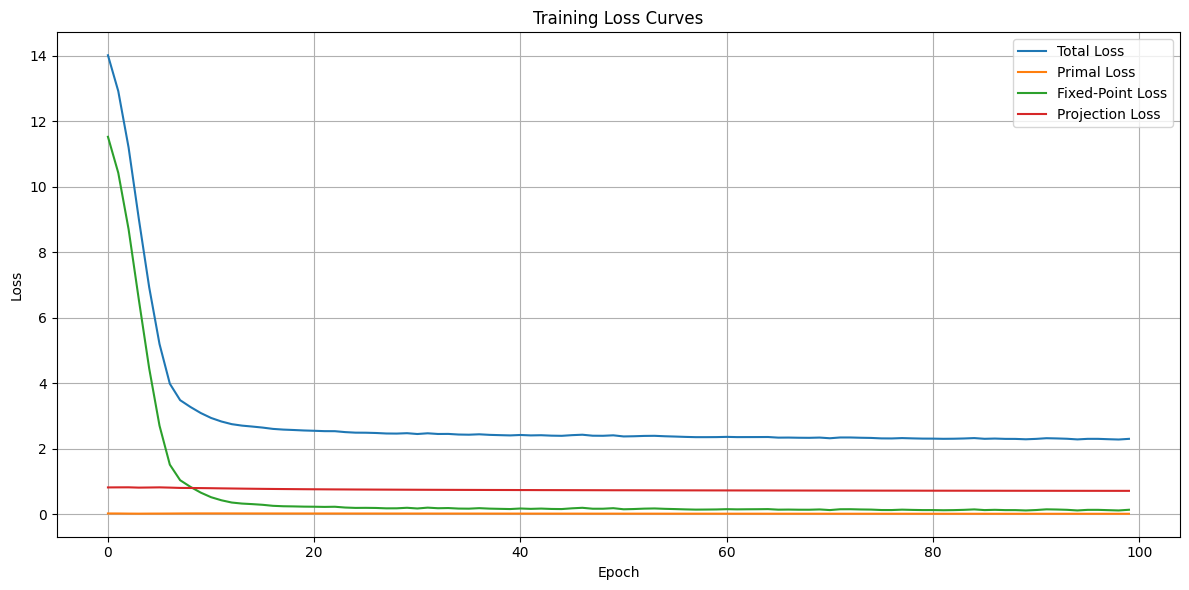

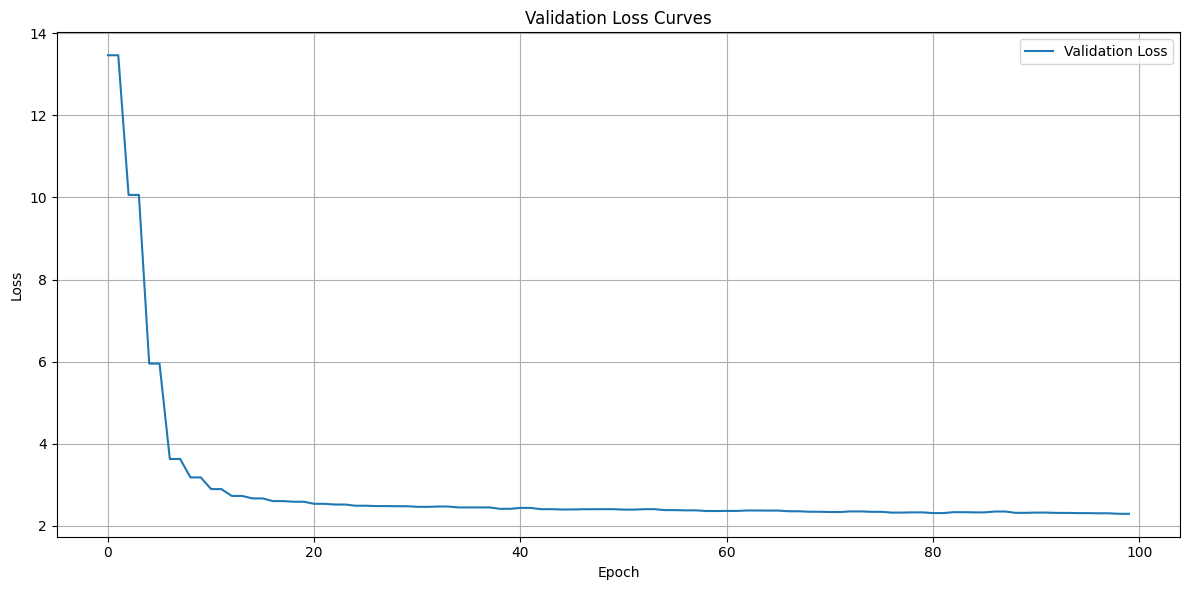

In [15]:
# Plot training losses

plt.figure(figsize=(12, 6))

plt.plot(avg_train_loss, label='Total Loss')
plt.plot(avg_primal_loss, label='Primal Loss')
plt.plot(avg_fixed_point_loss, label='Fixed-Point Loss')
plt.plot(avg_projection_loss, label='Projection Loss')


plt.title('Training Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot validation losses
plt.figure(figsize=(12, 6))
plt.plot(avg_val_loss, label='Validation Loss')

plt.title('Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
avg_train_loss = np.asarray(avg_train_loss)
avg_val_loss = np.asarray(avg_val_loss)
print("Training_loss_end", avg_train_loss[-1])
print("Validation_loss_end", avg_val_loss[-1])

print("max projection_loss", np.max(np.asarray(avg_projection_loss)))
print("min projection_loss", np.min(np.asarray(avg_projection_loss)))

Training_loss_end 2.3039389
Validation_loss_end 2.2907457
max projection_loss 0.8243352
min projection_loss 0.7164225
